Columns after initial cleaning: ['date', 'year', 'type', 'country', 'state', 'activity', 'sex', 'age', 'fatal', 'time']
Date reformatting - value counts:
 date
Unknown    193
06-2015     21
04-2017     21
09-2017     19
08-2014     19
          ... 
06-1827      1
1828-00      1
09-1828      1
1829-00      1
06-1829      1
Name: count, Length: 1684, dtype: int64
Seasonality percentage:
 seasonality
Summer    30.602837
Autumn    24.645390
Winter    23.226950
Spring    21.524823
Name: count, dtype: float64
Activity column - value counts:
 activity
Surfing                    1101
Swimming                    932
unknown                     502
Spearfishing                322
Fishing                     268
                           ... 
Jumped into river             1
Wreck of the USS Somers       1
Wreck of the Tweed            1
Wreck of the Sovereign        1
Hilo                          1
Name: count, Length: 1358, dtype: int64
Updated DataFrame:
       date    year        type    co

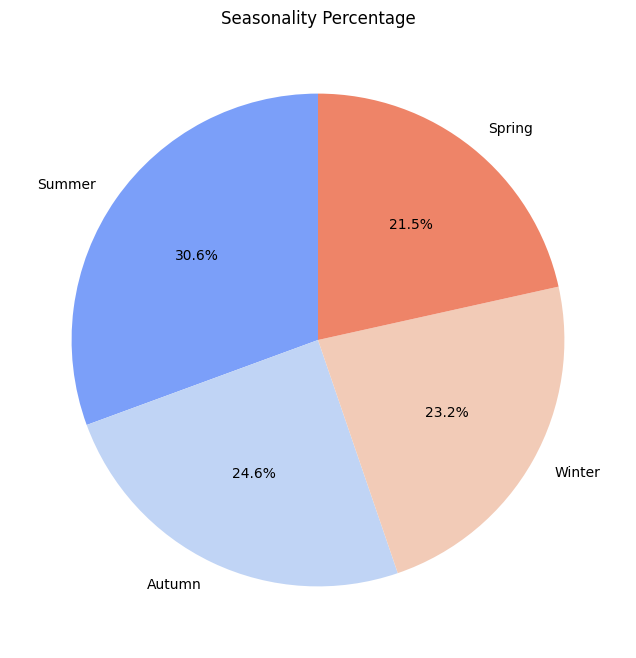

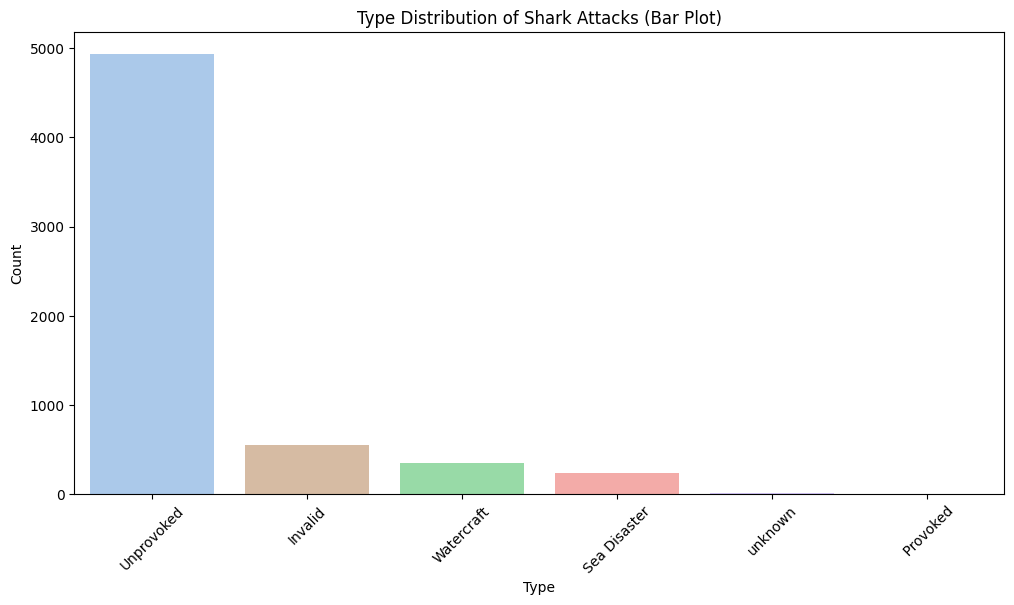

In [2]:
"""
# main_script.py

This script performs the following:
- Loads the shark attack dataset from a specified URL.
- Performs initial cleaning and preprocessing of the dataset.
- Executes specific column cleaning techniques.
- Reformats dates and adds seasonality information.
- Handles missing values in specific columns and creates a location column.
- Generates visualizations to provide insights into the dataset.

The script uses various functions from the following modules:
- `initial_setup`: Contains functions to load data and provide an initial preview.
- `data_cleaning`: Contains functions for initial cleaning and preparation of the DataFrame.
- `column_cleaning`: Contains functions for cleaning specific columns within the DataFrame.
- `feature_engineering`: Contains functions for feature engineering such as reformatting dates, adding seasonality, and handling NaNs.
- `visualizations`: Contains functions to generate visualizations.

Usage:
    Run this script to load, clean, preprocess the shark attack dataset and generate visualizations.
"""

# Import necessary functions and libraries
from modules.initial_setup import load_data, initial_preview
from modules.data_cleaning import initial_cleaning
from modules.column_cleaning import (clean_fatal_column, clean_sex_column, clean_type_column, clean_time_column, clean_age_column)
from modules.feature_engineering import (apply_date_reformatting, apply_seasonality, handle_activity_location_na)
from modules.visualizations import (plot_seasonality_pie_chart, plot_type_distribution_bar)

# Section 1: Initial Setup
url = 'https://www.sharkattackfile.net/spreadsheets/GSAF5.xls'
df = load_data(url)

# Uncomment to get an initial preview of the raw DataFrame
# initial_preview(df)

# Section 2: DataFrame Cleaning Preparation
df = initial_cleaning(df)
print("Columns after initial cleaning:", df.columns.tolist())

# Creating a copy of the cleaned DataFrame for further manipulation
df_copy = df.copy()

# Section 3: Cleaning Specific Columns
df_copy = clean_fatal_column(df_copy)
df_copy = clean_sex_column(df_copy)
df_copy = clean_type_column(df_copy)
df_copy = clean_time_column(df_copy)
df_copy = clean_age_column(df_copy)

# Section 4: Reformatting Dates and Adding Seasonality Information
df_copy = apply_date_reformatting(df_copy)
print("Date reformatting - value counts:\n", df_copy['date'].value_counts(dropna=False))

df_copy = apply_seasonality(df_copy)
valid_seasons_df = df_copy[df_copy['seasonality'] != "Unknown"]
season_counts = valid_seasons_df['seasonality'].value_counts()
total_count = len(valid_seasons_df)
season_percentage = (season_counts / total_count) * 100
print("Seasonality percentage:\n", season_percentage)

# Section 5: Handling NaNs in 'activity' and 'location'
df_copy = handle_activity_location_na(df_copy)
print("Activity column - value counts:\n", df_copy['activity'].value_counts(dropna=False))

# Final Output: Updated DataFrame
print("Updated DataFrame:\n", df_copy.head())

# Section 6: Visualizations
deaths_by_year = df_copy[df_copy['fatal'] == 'y'].groupby('year').size()

# Call visualization functions
plot_seasonality_pie_chart(season_counts)
plot_type_distribution_bar(df_copy)